In [16]:
import matplotlib.pyplot as plt
import numpy as np
import re

def run_minimap2(datasets):
    raw_data = []
    out_tmp_filename = 'minimap-profiling-tmp.out'
    for dataset in datasets:
        print(f'Running {dataset}')
        preset = 'map-pb' if dataset.startswith('PB') or 'pb' in dataset else 'map-ont'
        # ret = !./minimap2/minimap2 -a -x {preset} -t 1 ref.mmi {dataset} | awk -F '\t' '{{print $$5}}' > {out_tmp_filename}
        ret = !../minimap2 -cx {preset} -t 1 ref.mmi {dataset} | grep -Po 'de:f:\d+.\d+' | cut -c6- > {out_tmp_filename}
        mapping_qualities = np.loadtxt(out_tmp_filename, skiprows=3)
        results = [] # Order is always seed, chain, align
        for line in ret:
            if line.startswith('[TIMING::worker_pipeline'):
                results.append(float(re.findall('Took (\d+\.\d+) s to', line)[0]))
        results.append(len(mapping_qualities))
        results += [np.min(mapping_qualities), np.quantile(mapping_qualities, 0.25), np.quantile(mapping_qualities, 0.5), np.quantile(mapping_qualities, 0.75), np.max(mapping_qualities)]
        raw_data.append(results)
        print(f'Done running {dataset}, got {results}')
    return np.array(raw_data)

def plot_results(data, datasets, do_per=True, do_divergence=False, save_label=''):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    metadata = [('seed', '#CBB3BF'), ('chain', '#DBC7BE'), ('align', '#8DA1B9')] #95ADB6
    WIDTH = 0.5
    steps_data = data[:,:3]
    per_data = steps_data / steps_data.sum(axis=1, keepdims=1) * 100 if do_per else steps_data
    X = np.arange(len(datasets))
    bottom = np.zeros(len(X))
    value_formatter = '{:.1f}%' if do_per else '{:.2f}'
    for i, (label, color) in enumerate(metadata):
        ax.bar(X, per_data[:,i], label=label, color=color, width=WIDTH, bottom=bottom, zorder=2)
        bottom += per_data[:,i]
        for x, y, value in zip(X, bottom - per_data[:,i] / 2, per_data[:,i]):
            ax.text(x, y, value_formatter.format(value), horizontalalignment='center', verticalalignment='center')

    if do_divergence:
        mapping_qualities_data = data[:,-5:]
        mapping_cnts = data[:,-6]

        ax2 = ax.twinx()
        ax2.boxplot(np.transpose(mapping_qualities_data), positions=X)
        ax2.set_ylabel('Sequence divergence')
        ax2.set_xticks([])

    file_sizes = []
    for dataset in datasets:
        cnt = !wc -c <{dataset}
        file_sizes.append(int(cnt[0]) / 1e6)
    datasets_labels = ['{}\n{:.2f} MB'.format(e.replace('.fastq', '').replace('.gz', ''), s) for e, s in zip(datasets, file_sizes)]

    ax.set_xticks(X)
    ax.set_xticklabels(datasets_labels, rotation=45, ha='right', rotation_mode='anchor')
    
    ax.set_xlabel('Datasets')
    ax.set_ylabel('% of elapsed time' if do_per else 'Elapsed time (s)')
    if do_per:
        ax.set_ylim([0, 100])
    ax.grid(axis='y', linestyle='--')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], frameon=False, bbox_to_anchor=(0.5, 1.1), ncols=3, loc='upper center')

    plt.tight_layout()
    plt.show()

    if save_label != '':
        fig.savefig(save_label + '.svg')

In [3]:
# Compile
!cd .. && make

cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  main.c -o main.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  kthread.c -o kthread.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  kalloc.c -o kalloc.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  misc.c -o misc.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  bseq.c -o bseq.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  sketch.c -o sketch.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  sdust.c -o sdust.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  options.c -o options.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  index.c -o index.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  lchain.c -o lchain.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  align.c -o align.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  hit.c -o hit.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  seed.c -o seed.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  map.c -o map.o
cc -c -g -Wall -O2 -Wc++-compat  -DHAVE_KALLOC  format.c -o form

In [10]:
# Generate index
!../minimap2 -d ref.mmi chr2.fa.gz > /dev/null

[M::mm_idx_gen::7.752*0.99] collected minimizers
[M::mm_idx_gen::8.848*1.23] sorted minimizers
[TIMING::mm_idx_gen] Took 8.740 s to gen index
[M::main::10.303*1.20] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::10.555*1.19] distinct minimizers: 25485641 (72.26% are singletons); average occurrences: 1.760; average spacing: 5.420; total length: 243199373
[M::main] Version: 2.26-r1175
[M::main] CMD: ../minimap2 -d ref.mmi chr2.fa.gz
[M::main] Real time: 10.734 sec; CPU: 12.708 sec; Peak RSS: 1.991 GB


In [26]:
datasets1 = [
    'badread_ont_worse_35kb.fastq.gz',
    'badread_ont_bad_35kb.fastq.gz',
    'badread_ont_good_35kb.fastq.gz',
    'badread_ont_best_35kb.fastq.gz',
    'badread_pb_bad_35kb.fastq.gz',
    'badread_pb_best_35kb.fastq.gz',
    'simlord_pb_bad_35kb.fastq',
    'simlord_pb_good_35kb.fastq',
    'simlord_pb_best_35kb.fastq',
    'simlord_pb_best_35kb_chr3.fastq',
]
data1 = run_minimap2(datasets1)

Running badread_ont_worse_35kb.fastq.gz
Done running badread_ont_worse_35kb.fastq.gz, got [0.49, 0.17, 3.343, 0.106, 0.014, 0.036, 0.004, 1334, 0.012, 0.111025, 0.1418, 0.16749999999999998, 0.2702]
Running badread_ont_bad_35kb.fastq.gz
Done running badread_ont_bad_35kb.fastq.gz, got [0.513, 0.667, 0.951, 0.278, 0.036, 0.294, 0.027, 206, 0.0132, 0.033174999999999996, 0.0491, 0.05645, 0.2289]
Running badread_ont_good_35kb.fastq.gz
Done running badread_ont_good_35kb.fastq.gz, got [0.567, 0.951, 0.775, 0.31, 0.057, 0.484, 0.048, 149, 0.0016, 0.0064, 0.0096, 0.0149, 0.0329]
Running badread_ont_best_35kb.fastq.gz
Done running badread_ont_best_35kb.fastq.gz, got [0.6, 1.431, 0.718, 0.591, 0.073, 0.641, 0.06, 140, 0.0002, 0.0007, 0.0011, 0.0016, 0.0075]
Running badread_pb_bad_35kb.fastq.gz
Done running badread_pb_bad_35kb.fastq.gz, got [0.53, 0.856, 0.996, 0.416, 0.04, 0.337, 0.029, 183, 0.0133, 0.0309, 0.0475, 0.0714, 0.202]
Running badread_pb_best_35kb.fastq.gz
Done running badread_pb_best_3

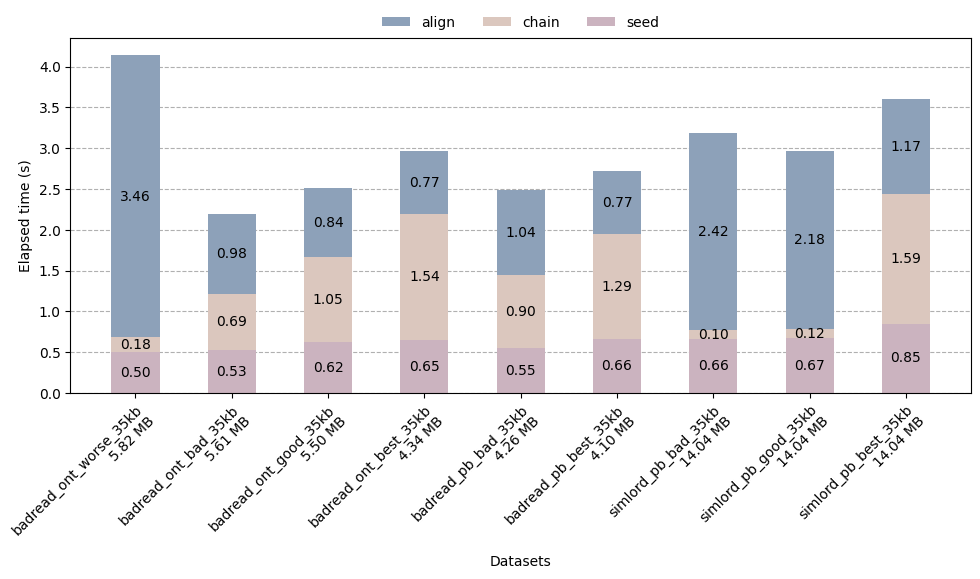

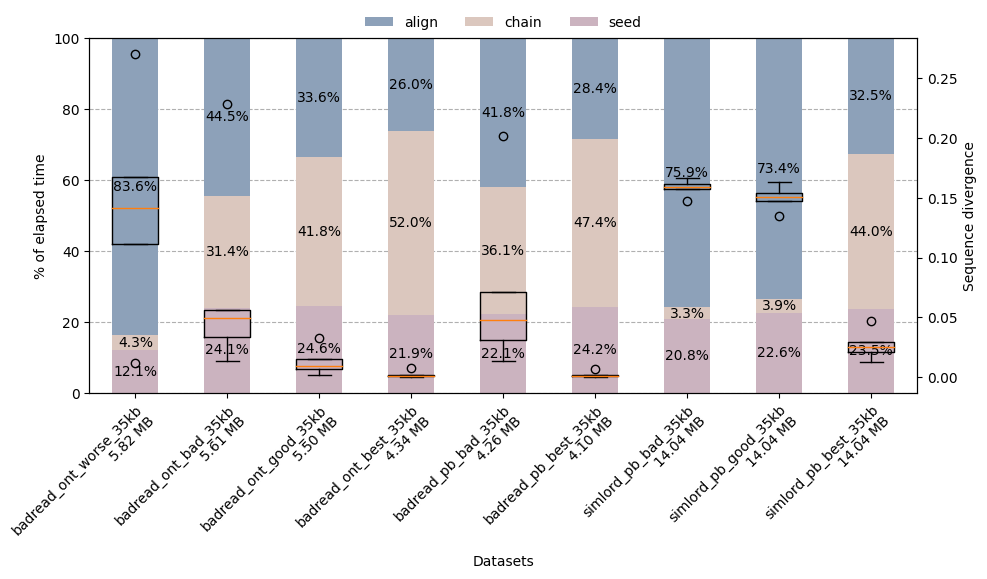

In [21]:
plot_results(data1, datasets1, do_per=False, save_label='1')
plot_results(data1, datasets1, do_per=True, do_divergence=True, save_label='1div')

In [24]:
datasets2 = [
    'badread_ont_bad_15kb.fastq.gz',
    'badread_ont_bad_35kb.fastq.gz',
    'badread_ont_bad_75kb.fastq.gz',
    'badread_ont_bad_110kb.fastq.gz',
    'badread_ont_best_15kb.fastq.gz',
    'badread_ont_best_35kb.fastq.gz',
    'badread_ont_best_75kb.fastq.gz',
    'badread_ont_best_110kb.fastq.gz',
    'simlord_pb_best_15kb.fastq',
    'simlord_pb_best_35kb.fastq',
    'simlord_pb_best_75kb.fastq',
    'simlord_pb_best_110kb.fastq',
]
data2 = run_minimap2(datasets2)

Running badread_ont_bad_15kb.fastq.gz
Done running badread_ont_bad_15kb.fastq.gz, got [0.55, 0.592, 0.983, 0.233, 0.04, 0.258, 0.027, 342, 0.0108, 0.0305, 0.0416, 0.05605, 0.1897]
Running badread_ont_bad_35kb.fastq.gz
Done running badread_ont_bad_35kb.fastq.gz, got [0.532, 0.7, 0.97, 0.292, 0.038, 0.308, 0.028, 206, 0.0132, 0.033174999999999996, 0.0491, 0.05645, 0.2289]
Running badread_ont_bad_75kb.fastq.gz
Done running badread_ont_bad_75kb.fastq.gz, got [0.525, 1.88, 0.891, 1.372, 0.05, 0.387, 0.034, 65, 0.0091, 0.0278, 0.0362, 0.0459, 0.1163]
Running badread_ont_bad_110kb.fastq.gz
Done running badread_ont_bad_110kb.fastq.gz, got [0.507, 0.841, 0.85, 0.381, 0.04, 0.356, 0.03, 75, 0.0135, 0.03665, 0.0756, 0.17909999999999998, 0.3014]
Running badread_ont_best_15kb.fastq.gz
Done running badread_ont_best_15kb.fastq.gz, got [0.618, 1.114, 0.732, 0.376, 0.071, 0.544, 0.058, 349, 0.0001, 0.0006, 0.001, 0.0015, 0.0092]
Running badread_ont_best_35kb.fastq.gz
Done running badread_ont_best_35kb.

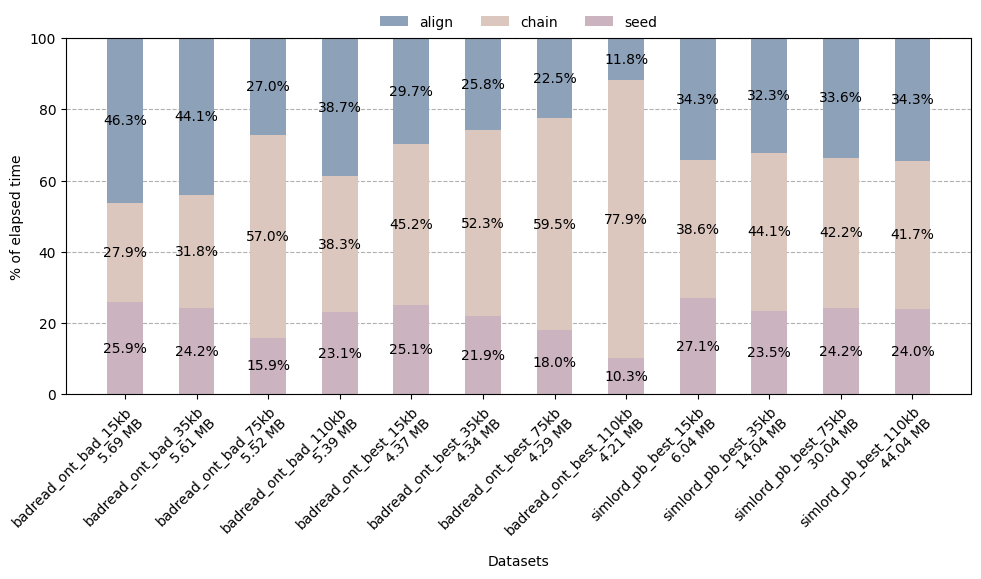

In [25]:
plot_results(data2, datasets2, do_per=True, save_label='2')